Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/ISIC/Train/")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/ISIC/Test/')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset180 here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(directory=data_dir_train,
                                                               image_size=(img_height,img_width),
                                                               batch_size=batch_size,
                                                               seed = 123,
                                                               validation_split=0.20,
                                                               subset='training')

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(directory=data_dir_train,
                                                               image_size=(img_height,img_width),
                                                               batch_size=32,
                                                               seed = 123,
                                                               validation_split=0.20,
                                                               subset='validation')##todo

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

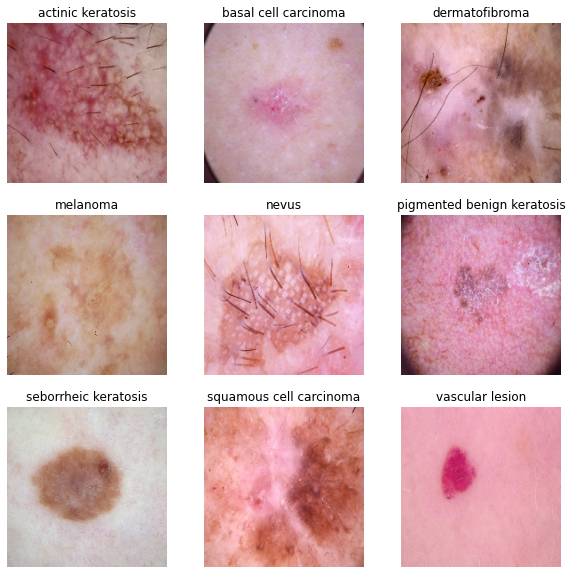

In [55]:
import matplotlib.pyplot as plt
### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10, 10))
for i in range(len(class_names)):
    filtered_ds = train_ds.filter(lambda x, l: tf.math.equal(l[0], i))
    for image, label in filtered_ds.take(1):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(image[0].numpy().astype('uint8'))
        plt.title(class_names[label.numpy()[0]])
        plt.axis('off')

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [13]:
### Your code goes here

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(len(class_names)),
  layers.Activation('softmax')
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [15]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
# View the summary of all layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 64)       

### Train the model

In [17]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 534s 2s/step - loss: 1.9967 - accuracy: 0.2846 - val_loss: 1.7793 - val_accuracy: 0.3490
Epoch 2/20
56/56 [==============================] - 2s 43ms/step - loss: 1.6610 - accuracy: 0.4169 - val_loss: 1.5675 - val_accuracy: 0.4698
Epoch 3/20
56/56 [==============================] - 2s 41ms/step - loss: 1.4625 - accuracy: 0.4827 - val_loss: 1.4407 - val_accuracy: 0.4899
Epoch 4/20
56/56 [==============================] - 2s 41ms/step - loss: 1.3363 - accuracy: 0.5352 - val_loss: 1.4051 - val_accuracy: 0.5347
Epoch 5/20
56/56 [==============================] - 2s 41ms/step - loss: 1.2823 - accuracy: 0.5430 - val_loss: 1.3737 - val_accuracy: 0.5391
Epoch 6/20
56/56 [==============================] - 2s 41ms/step - loss: 1.1998 - accuracy: 0.5753 - val_loss: 1.4049 - val_accuracy: 0.5391
Epoch 7/20
56/56 [==============================] - 2s 41ms/step - loss: 1.1174 - accuracy: 0.6038 - val_loss: 1.4568 - val_accuracy: 0.5302
Epoch 8/20
56

### Visualizing training results

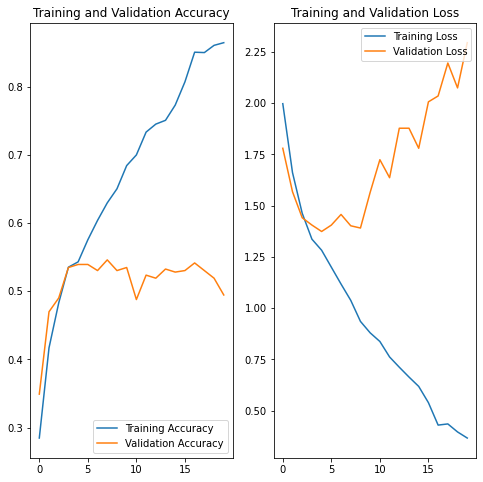

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

In [35]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here

# The model is clearly overfitting seeing how training accuracy rises but validation accuracy is stagnated
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])


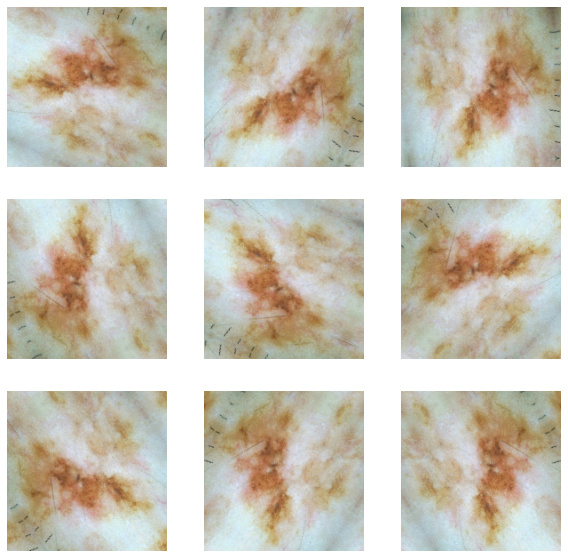

In [36]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
import random
filtered_ds = train_ds.filter(lambda x, l: tf.math.equal(l[0], random.randint(0,8)))
for image, label in filtered_ds.take(1):
    image_mod = image[0].numpy().astype('uint8')
image_mod = tf.expand_dims(image_mod, 0)

plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image_mod)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")


### Todo:
### Create the model, compile and train the model


In [65]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    # data_augmentation,
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(class_names)),
    layers.Activation('softmax')
])


### Compiling the model

In [133]:
## Your code goes here
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_11 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_57 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 batch_normalization_34 (Bat  (None, 180, 180, 16)     64        
 chNormalization)                                                
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 dropout_34 (Dropout)        (None, 90, 90, 16)        0         
                                                                 
 conv2d_58 (Conv2D)          (None, 90, 90, 32)      

### Training the model

In [67]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 3s 48ms/step - loss: 2.2130 - accuracy: 0.1808 - val_loss: 2.0874 - val_accuracy: 0.3400
Epoch 2/20
56/56 [==============================] - 3s 45ms/step - loss: 1.9954 - accuracy: 0.2411 - val_loss: 1.8785 - val_accuracy: 0.3535
Epoch 3/20
56/56 [==============================] - 3s 45ms/step - loss: 1.7940 - accuracy: 0.3376 - val_loss: 1.8454 - val_accuracy: 0.3512
Epoch 4/20
56/56 [==============================] - 3s 45ms/step - loss: 1.6968 - accuracy: 0.3767 - val_loss: 1.7940 - val_accuracy: 0.3177
Epoch 5/20
56/56 [==============================] - 3s 45ms/step - loss: 1.6829 - accuracy: 0.3778 - val_loss: 1.6468 - val_accuracy: 0.3826
Epoch 6/20
56/56 [==============================] - 3s 45ms/step - loss: 1.6604 - accuracy: 0.3789 - val_loss: 1.6291 - val_accuracy: 0.4161
Epoch 7/20
56/56 [==============================] - 3s 47ms/step - loss: 1.5957 - accuracy: 0.4057 - val_loss: 1.5713 - val_accuracy: 0.4407
Epoch 8/20
56

### Visualizing the results

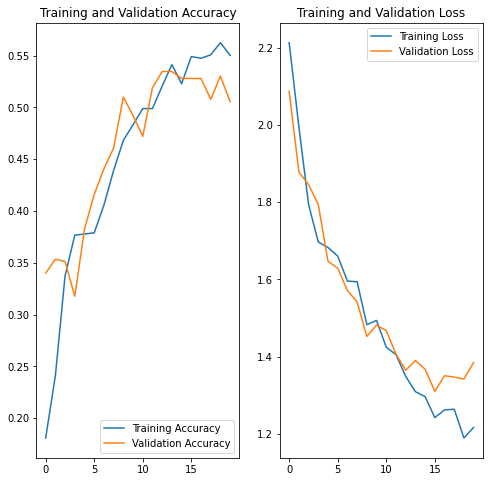

In [68]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

**The overall accuracy has reduced. but now the training and validation accuracy are moving toether in the positive direction and loss for the same reduced**
- The model might benifit from adding more layers and features

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

5    20.65
3    19.64
1    17.24
4    15.46
7     7.92
8     6.42
0     5.13
2     4.30
6     3.24
dtype: float64


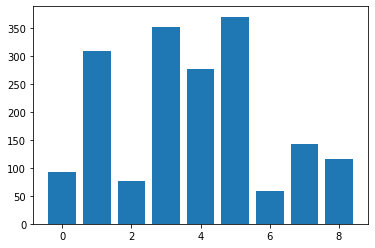

In [94]:
## Your code goes here.

labels_train = pd.Series(np.concatenate([y for x, y in train_ds], axis=0))
print(np.round(labels_train.value_counts(normalize=True)*100,2))
plt.bar(labels_train.value_counts().index,labels_train.value_counts())
plt.show()

In [95]:
print(class_names[6],class_names[5])

seborrheic keratosis pigmented benign keratosis


<!-- #### **Todo:** Write your findings here:  -->
#### - Which class has the least number of samples?
Class 6 (seborrheic keratosis) - has only 3.24% of the total training dataset
#### - Which classes dominate the data in terms proportionate number of samples?
Class 5 (pigmented benign keratosis) - has the 20.65% of the total training datset


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [69]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [96]:
path_to_training_dataset="/content/gdrive/MyDrive/ISIC/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/ISIC/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FBB9C142E50>: 100%|██████████| 500/500 [00:21<00:00, 22.94 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/ISIC/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FBB9C2F4A90>: 100%|██████████| 500/500 [00:21<00:00, 23.41 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/ISIC/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FBB9C2A4790>: 100%|██████████| 500/500 [00:22<00:00, 21.98 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/ISIC/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FBB9C8B74D0>: 100%|██████████| 500/500 [01:57<00:00,  4.26 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/ISIC/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=959x723 at 0x7FBB9C172950>: 100%|██████████| 500/500 [01:40<00:00,  4.96 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/ISIC/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FBB9C2EDB90>: 100%|██████████| 500/500 [00:21<00:00, 23.67 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/ISIC/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FBB9C2C75D0>: 100%|██████████| 500/500 [00:46<00:00, 10.65 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/ISIC/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FBB9C451350>: 100%|██████████| 500/500 [00:21<00:00, 23.51 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/ISIC/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FBB9C291D10>: 100%|██████████| 500/500 [00:22<00:00, 22.22 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [97]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [114]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','*.jpg'))]
path_list[0]

'/content/gdrive/MyDrive/ISIC/Train/melanoma/ISIC_0000143.jpg'

In [116]:
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*','*.jpg'))]
lesion_list[0]

'melanoma'

In [117]:
dataframe_dict_orignal = dict(zip(path_list, lesion_list))

In [119]:
original_df = pd.DataFrame(list(dataframe_dict_orignal.items()),columns = ['Path','Label'])

In [118]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new[0]

'/content/gdrive/MyDrive/ISIC/Train/melanoma/output/melanoma_original_ISIC_0010131.jpg_e5839371-add9-449d-b0d7-99a471a40a81.jpg'

In [112]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new[0]

'melanoma'

In [113]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [120]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [121]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [122]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [124]:
data_dir_train='/content/gdrive/MyDrive/ISIC/Train/'#"path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [126]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [127]:
## your code goes here
model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    # data_augmentation,
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(16, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),

    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),

    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),

    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(class_names)),
    layers.Activation('softmax')
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [134]:
## your code goes here
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_11 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_57 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 batch_normalization_34 (Bat  (None, 180, 180, 16)     64        
 chNormalization)                                                
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 dropout_34 (Dropout)        (None, 90, 90, 16)        0         
                                                                 
 conv2d_58 (Conv2D)          (None, 90, 90, 32)      

#### **Todo:**  Train your model

In [135]:
epochs = 30
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
) # your model fit code

Epoch 1/30
169/169 [==============================] - 41s 233ms/step - loss: 3.0239 - accuracy: 0.2070 - val_loss: 25.7775 - val_accuracy: 0.1158
Epoch 2/30
169/169 [==============================] - 40s 232ms/step - loss: 1.9780 - accuracy: 0.2502 - val_loss: 18.1652 - val_accuracy: 0.1218
Epoch 3/30
169/169 [==============================] - 40s 231ms/step - loss: 1.9131 - accuracy: 0.2617 - val_loss: 11.6187 - val_accuracy: 0.2301
Epoch 4/30
169/169 [==============================] - 41s 238ms/step - loss: 1.8877 - accuracy: 0.2899 - val_loss: 2.2401 - val_accuracy: 0.2925
Epoch 5/30
169/169 [==============================] - 42s 241ms/step - loss: 1.7752 - accuracy: 0.3086 - val_loss: 2.5157 - val_accuracy: 0.3348
Epoch 6/30
169/169 [==============================] - 40s 229ms/step - loss: 1.7407 - accuracy: 0.3164 - val_loss: 1.8648 - val_accuracy: 0.2829
Epoch 7/30
169/169 [==============================] - 40s 231ms/step - loss: 1.6543 - accuracy: 0.3490 - val_loss: 1.5304 - val

#### **Todo:**  Visualize the model results

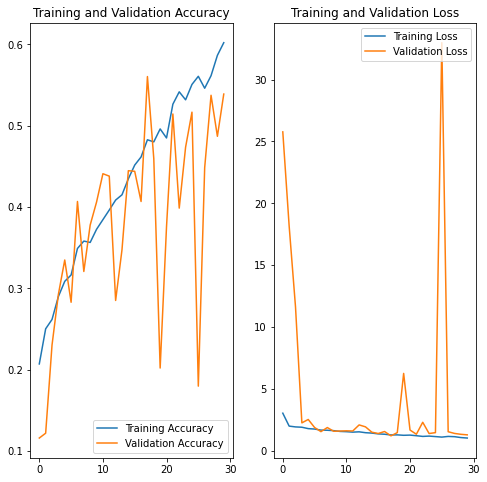

In [136]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

